In [1]:
import os
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [19]:
class LidarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, hidden3_size, outputs_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, outputs_size)
            # nn.Linear(hidden2_size, hidden3_size),
            # nn.ReLU(),
            # nn.Linear(hidden3_size, hidden4_size),
            # nn.ReLU(),
            # nn.Linear(hidden4_size, outputs_size)
        )

    def forward(self, x):

        return self.model(x)

In [7]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/data_3rounds"

data_file = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X = torch.Tensor(np.array(data_file.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y = torch.Tensor(np.array(data_file.iloc[:, 16:17], copy=False))

print(X)
print(Y[0].type())
print(data_file.head())

tensor([[ 7.4593,  6.8660,  8.4048,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        ...,
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000]])
torch.FloatTensor
        0       1       2        3        4        5       6       7        8  \
0  7.4593  6.8660  8.4048  10.2781  12.9475   9.7540  5.7571  5.8859   3.9555   
1  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
2  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
3  7.4566  6.8634  8.4025  10.2759  12.9456  11.2519  5.7557  5.8850  20.0000   
4  7.4507  6.8577  8.3973  10.2711  12.9414  11.2484  5.7526  5.8828  20.0000   

      9    10      11      12      13      14      15    16  

LidarBrain(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


100%|██████████| 200/200 [08:35<00:00,  2.58s/it]

[135.12340884899507, 86.09725517305584, 75.87786605562272, 70.99032465383098, 68.09133356904763, 66.48053100477509, 64.32683396771276, 61.84793214143288, 59.7635509297107, 57.52704624575894, 55.17054262381595, 52.78390813190146, 50.69507999219298, 48.43238465750739, 46.25865543410106, 44.28936091511242, 42.50985777001258, 40.71481937379492, 38.82629045747473, 37.313186285106674, 35.712605499042084, 34.38981770117096, 32.892599980898204, 31.88318524690852, 30.836705000127274, 29.866268123898752, 28.80795354007614, 27.873659023927022, 26.760006455579468, 25.96749103865212, 25.13275533224869, 24.283878327945274, 23.61304253849444, 22.96217121564873, 22.37967375263424, 21.733469615686726, 21.04536028013873, 20.4251572734636, 20.102412541850867, 19.752458050284485, 19.400783314512367, 18.92975688871966, 18.574044828174625, 18.15617859735506, 17.811938407375337, 17.67242375551395, 17.34203140153351, 16.94104954420806, 16.566364223279166, 16.302657389763827, 15.929199072985533, 15.63196458116

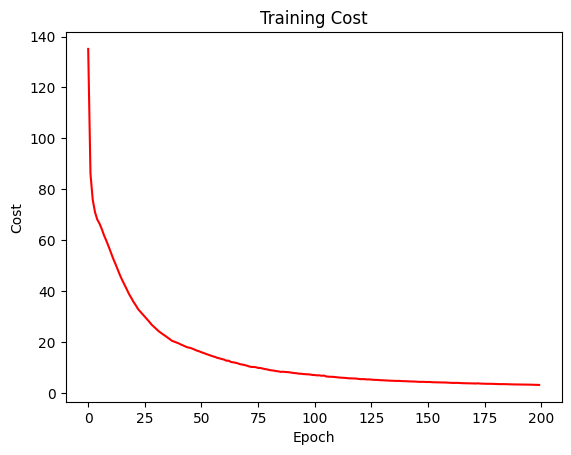

In [35]:
epochs = 200

learningRate = 0.000007

#----------------------------------------

lb = LidarBrain(16, 128, 128, 128, 1)

print(lb)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(lb.parameters(), lr=learningRate)

#----------------------------------------

for i in tqdm(range(epochs)):

    losses_epoch = []
    for x, y in zip(X, Y):
    
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()

        # Forward step
        yhat = lb(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()

    losses.append(sum(losses_epoch)/len(losses_epoch))

print(losses)

#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

#----------------------------------------

In [36]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/LidarBrain.pkl"

pickle.dump(lb.model, open(save_path, 'wb'))